In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.read_csv('../data/processed/qm9_clean.csv')
words = df['smiles'].astype('str').tolist()

In [4]:
print(words[:10])
print(len(words))

['C', 'N', 'O', 'C#C', 'C#N', 'C=O', 'CC', 'CO', 'CC#C', 'CC#N']
133885


In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: '#', 2: '(', 3: ')', 4: '+', 5: '-', 6: '1', 7: '2', 8: '3', 9: '4', 10: '5', 11: '=', 12: 'C', 13: 'F', 14: 'H', 15: 'N', 16: 'O', 17: '[', 18: ']', 0: '.'}
19


In [6]:
# dataset
block_size = 8

def build_dataset(words):

    X, Y =  [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            
            # print(''.join(itos[i] for i in context), ' --->' , itos[ix])
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8* len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
        
    

torch.Size([1737037, 8]) torch.Size([1737037])
torch.Size([217037, 8]) torch.Size([217037])
torch.Size([217214, 8]) torch.Size([217214])


In [55]:
# Using MLP
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size,n_embd, generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden,  vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0


bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, b1, W2, b2, bnbias, bngain]
for p in parameters:
    p.requires_grad = True

In [56]:
print(sum(p.nelement() for p in parameters))

20609


In [58]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix] , Ytr[ix]
    
    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1  # + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact =bngain* (hpreact - bnmeani)/ bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix])
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 2.9597
  10000/ 200000: 1.0521
  20000/ 200000: 1.1243
  30000/ 200000: 0.9629
  40000/ 200000: 1.2773
  50000/ 200000: 1.0991
  60000/ 200000: 1.0430
  70000/ 200000: 1.1447
  80000/ 200000: 1.1804
  90000/ 200000: 0.9705
 100000/ 200000: 0.8572
 110000/ 200000: 0.9473
 120000/ 200000: 1.0966
 130000/ 200000: 1.0206
 140000/ 200000: 0.9392
 150000/ 200000: 1.0248
 160000/ 200000: 0.8847
 170000/ 200000: 0.9336
 180000/ 200000: 1.0058
 190000/ 200000: 1.1143


(array([515., 249., 162., 154., 122., 109., 107., 119., 103., 109., 107.,
         81., 100.,  91.,  86., 100.,  73.,  98.,  99., 110., 140., 113.,
        105., 100., 119., 121., 108.,  95.,  96., 110.,  80.,  88.,  92.,
        115., 107.,  94.,  88.,  72.,  92.,  94.,  87., 115., 105., 117.,
        121., 140., 130., 166., 216., 480.]),
 array([-1.00000000e+00, -9.60000219e-01, -9.20000439e-01, -8.80000658e-01,
        -8.40000877e-01, -8.00001097e-01, -7.60001316e-01, -7.20001535e-01,
        -6.80001755e-01, -6.40001974e-01, -6.00002193e-01, -5.60002413e-01,
        -5.20002632e-01, -4.80002851e-01, -4.40003071e-01, -4.00003290e-01,
        -3.60003510e-01, -3.20003729e-01, -2.80003948e-01, -2.40004168e-01,
        -2.00004387e-01, -1.60004606e-01, -1.20004826e-01, -8.00050449e-02,
        -4.00052643e-02, -5.48362732e-06,  3.99942970e-02,  7.99940777e-02,
         1.19993858e-01,  1.59993639e-01,  1.99993420e-01,  2.39993200e-01,
         2.79992981e-01,  3.19992762e-01,  3.59992

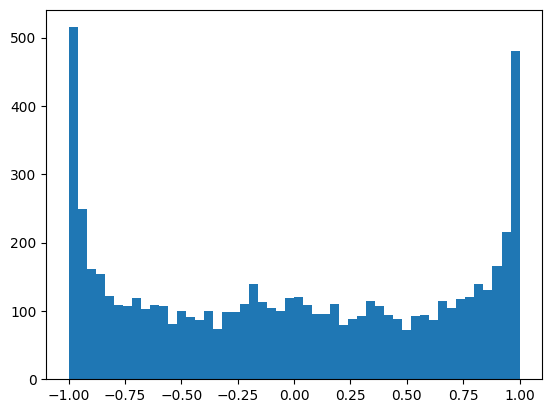

In [48]:
plt.hist(h.view(-1).tolist(), 50)

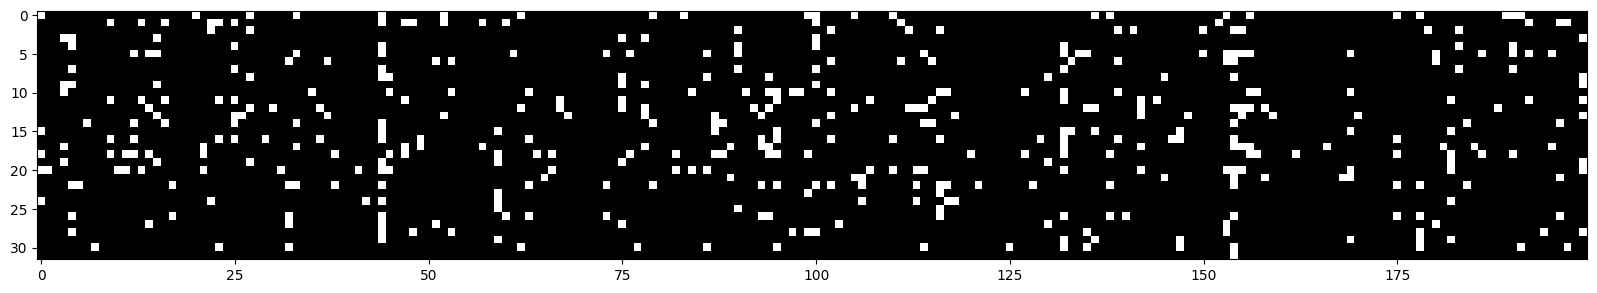

In [49]:
plt.figure(figsize=((20, 10)))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

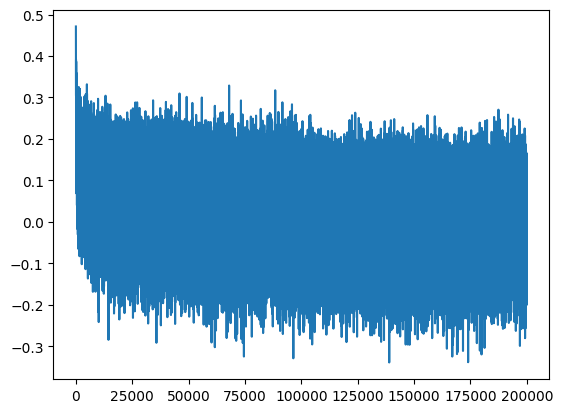

In [50]:
plt.plot(lossi)

In [51]:
# calibrate batch norm

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [52]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    batch_size = 1000 
    losses = []
    
    for i in range(0, x.shape[0], batch_size):
        xb = x[i:i+batch_size]
        yb = y[i:i+batch_size]
        
        # Forward pass 
        emb = C[xb]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        hpreact =bngain* (hpreact - bnmean) / bnstd + bnbias
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, yb)
        
        losses.append(loss.item())
    
    # Average the losses from all batches
    total_loss = sum(losses) / len(losses)
    print(split, total_loss)

split_loss('train')
split_loss('val')

train 1.6363056284923136
val 1.6385435390909877


In [13]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    # block_size=3
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor( [context] )] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

CN(C)C1(C)COC(C1)OC1=O.
CC1(C)C2(CO)C#N.
CCC1=NNCC1CC1CO.
O=CC1=NOC=N1.
OCC12OC(=N)C=C1.
CN(C)(O)CC#C.
CC1C2CC(NO)C1=O.
OC1CC1=C(C=N)C2.
CC1CC1C23.
CC1(C)ON=CCC=O3.
COC1CCC(C=O)(N)=C1.
CCC1C2C(O1)C2=NN2CO1.
OCC1(NC1=NO)C2O.
OCC1C2CC3C(C3)NC2C(C#C)N11.
CCOC1=CCC#NC=O.
OC1(COC2)C1C#N.
CC12C3C4(CC41)O.
NC1=C=O.
OCC12COC(C#C)C12.
OC=C1N=C(O)C2C.


In [7]:
# building a deeper network

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
   
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
            

182028


In [8]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break
    

      0/ 200000: 2.9482


layer 1 (      Tanh): mean -0.01, std 0.77, saturated" 22.05%
layer 3 (      Tanh): mean +0.02, std 0.69, saturated" 10.69%
layer 5 (      Tanh): mean -0.00, std 0.66, saturated" 6.39%
layer 7 (      Tanh): mean +0.01, std 0.66, saturated" 6.50%
layer 9 (      Tanh): mean -0.05, std 0.65, saturated" 5.92%


Text(0.5, 1.0, 'Activation Dist')

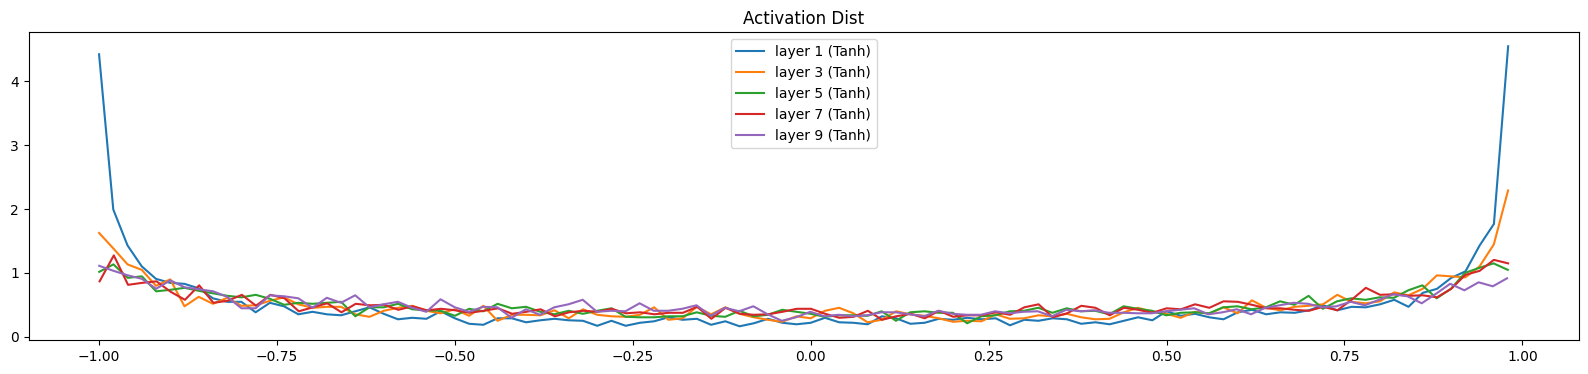

In [63]:
# histogram
plt.figure(figsize=(20,4))

legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated" %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends)
plt.title("Activation Dist")

layer 1 (      Tanh): mean -0.00, std 0.00, saturated" 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated" 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated" 0.00%
layer 7 (      Tanh): mean -0.00, std 0.00, saturated" 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated" 0.00%


Text(0.5, 1.0, 'Activation Dist')

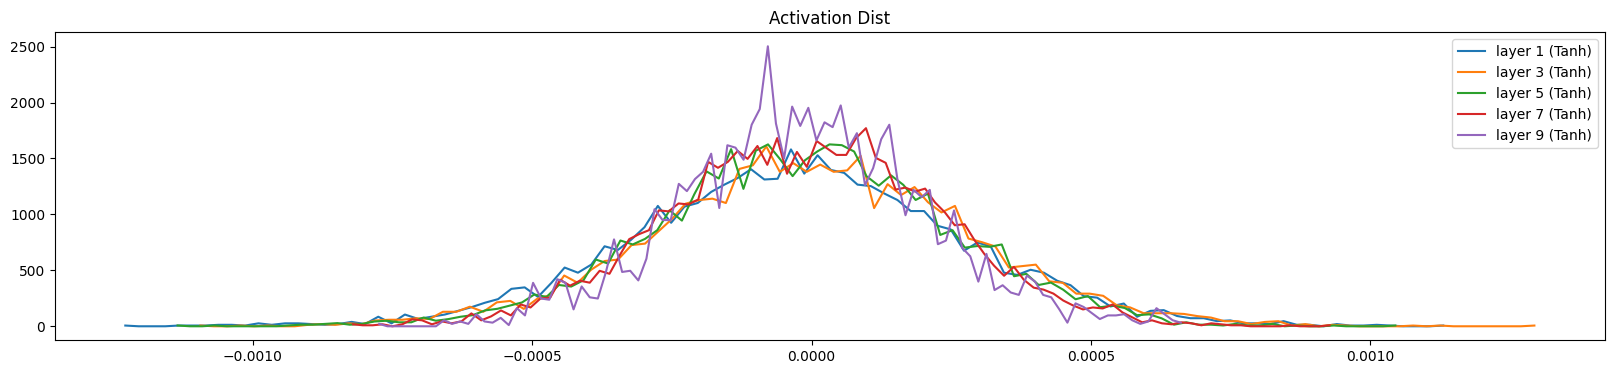

In [64]:
# histogram
plt.figure(figsize=(20,4))

legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated" %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends)
plt.title("Activation Dist")

In [ ]:
plt.figure(figsize=(20,4))
legends = []

for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends);